In [1]:
#!pip3 install tensorflow==2.3.0
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)

from tensorflow.keras.layers import Input, InputLayer, Dense, Flatten, Conv2D,Activation, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import MaxPooling2D
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import  Model
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
import os, cv2
import pywt
import time

2.4.0
2.4.0


In [2]:
def read_image(im_path, level=8):
  img = cv2.imread(im_path,0)
  img = cv2.resize(img,(256,256))
  out = np.zeros((256,256))
  for i in range(0,8):
    row = img.shape[0]
    col = img.shape[1]
    cA,(cH,cV,cD) = pywt.dwt2(img,'haar')
    out[0:(row//2),0:(col//2)] = cA
    out[0:(row//2),(col//2):col] = cH
    out[(row//2):row,0:(col//2)] = cV
    out[(row//2):row,(col//2):col] = cD
    img = cA
    
  #out[0,0] = 0
  out[0:(row//2),0:(col//2)] = 0

  for j in range(0,6):
    row = img.shape[0]
    col = img.shape[1]
    cA = out[0:row,0:col]
    cH = out[0:row,col:2*col]
    cV = out[row:2*row,0:col]
    cD = out[row:2*row,col:2*col]
    img = pywt.idwt2((cA,(cH,cV,cD)),'haar')
    out[0:2*row,0:2*col] = img
    

  return img

In [3]:
train_data = '/content/drive/MyDrive/Brain Cancer/Train Data'


x_train, y_train = [],[]
list_folder=os.listdir(path = train_data)
encoder = OneHotEncoder()
for i in list_folder:
  new_path = os.path.join(train_data,i) 
  pic_list = os.listdir(new_path)                                         
  for img in pic_list:  
    im_path = os.path.join(new_path,img)
    im_dwt = read_image(im_path)
    if i == 'flair':
      label = 0
    elif i == 't1':
      label = 1
    elif i == 't1ce':
      label = 2
    elif i == 't2':
      label = 3
    x_train.append(im_dwt) 
    y_train.append(label)

X_train = np.array(x_train).reshape(-1,64,64,1)
X_train = X_train/255
y_train = np.array(y_train).reshape(-1,1)
y_train = encoder.fit_transform(y_train)
Y_train = y_train.toarray()
print("Train images reading is done")

test_data = '/content/drive/MyDrive/Brain Cancer/Test Data for RPi'
x_test, y_test = [], []
list_folder=os.listdir(path = test_data)
for i in list_folder:
  new_path=os.path.join(test_data,i) 
  pic_list=os.listdir(new_path)                                              
  for img in pic_list:  
    im_path = os.path.join(new_path,img)
    im_dwt = read_image(im_path)
    if i == 'flair':
      label = 0
    elif i == 't1':
      label = 1
    elif i == 't1ce':
      label = 2
    elif i == 't2':
      label = 3
    x_test.append(im_dwt) 
    y_test.append(label) 

print("Test images reading is done")
X_test = np.array(x_test).reshape(-1,64,64,1)
X_test = X_test/255
y_test = np.array(y_test).reshape(-1,1)
y_test = encoder.fit_transform(y_test)
Y_test = y_test.toarray()

Train images reading is done
Test images reading is done


In [4]:
print('Dimensions of images:',X_train.shape[1:])
print('Number of images in training set :',X_train.shape[0])
print('Number of images in testing set :',X_test.shape[0])

Dimensions of images: (64, 64, 1)
Number of images in training set : 769
Number of images in testing set : 193


In [5]:
train_labels = np.argmax(Y_train, axis=-1)
flair_class = 0
t1_class = 0
t1ce_class = 0 
t2_class = 0

for i in range(len(train_labels)):
  if train_labels[i] == 0:
    flair_class += 1
  elif train_labels[i] == 1:
    t1_class += 1
  elif train_labels[i] == 2:
    t1ce_class += 1
  elif train_labels[i] == 3:
    t2_class += 1


if flair_class + t1_class + t1ce_class + t2_class == X_train.shape[0]:
  print('Everything is okay.')
  print('No of flair_class in Train set: ',flair_class)
  print('No of t1_class in Train set: ',t1_class)
  print('No of t1ce_class in Train set: ',t1ce_class)
  print('No of t2_class in Train set: ',t2_class)
else:
  print("Something is wrong!")

Everything is okay.
No of flair_class in Train set:  189
No of t1_class in Train set:  206
No of t1ce_class in Train set:  184
No of t2_class in Train set:  190


In [6]:
weight_for_flair = (flair_class + t1_class + t1ce_class + t2_class)/(4.0*flair_class)
weight_for_t1 = (flair_class + t1_class + t1ce_class + t2_class)/(4*t1_class)
weight_for_t1ce = (flair_class + t1_class + t1ce_class + t2_class)/(4*t1ce_class)
weight_for_t2 = (flair_class + t1_class + t1ce_class + t2_class)/(4*t2_class)

class_weight = {0: weight_for_flair, 1: weight_for_t1, 2: weight_for_t1ce, 3: weight_for_t2}
print('Weight for class 0: {:.2f}'.format(weight_for_flair))
print('Weight for class 1: {:.2f}'.format(weight_for_t1))
print('Weight for class 2: {:.2f}'.format(weight_for_t1ce))
print('Weight for class 3: {:.2f}'.format(weight_for_t2))

Weight for class 0: 1.02
Weight for class 1: 0.93
Weight for class 2: 1.04
Weight for class 3: 1.01


In [7]:
inputShape=(64,64,1)
input1 = Input(inputShape)


x = Conv2D(4,(3,3), name='layer_conv1', activation = 'relu', padding='same')(input1)
x = Conv2D(8,(3,3), name='layer_conv2', activation = 'relu', padding='same')(x)
x = MaxPooling2D((2,2), name = 'max_pool1', padding='same')(x)
x = Conv2D(16,(3,3), name='layer_conv3', activation = 'relu', padding='same')(x)
x = Conv2D(32,(3,3), name='layer_conv4', activation = 'relu', padding='same')(x)
x = MaxPooling2D((2,2), name = 'max_pool2', padding='same')(x)
x = Conv2D(64,(3,3), name='layer_conv5', activation = 'relu')(x)
x = MaxPooling2D((2,2), name = 'max_pool5', padding='same')(x)
x = Conv2D(128,(3,3), name='layer_conv6', activation = 'relu')(x)
x = MaxPooling2D((2,2), name = 'max_pool6', padding='same')(x)
x = Flatten()(x)
x = Dense(64,activation = 'relu',name='fc0')(x)
x = Dropout(0.2)(x)
x = Dense(32,activation = 'relu',name='fc1')(x)
x = Dropout(0.2)(x)
x = Dense(32,activation = 'relu',name='fc2')(x)
x = Dropout(0.25)(x)
x = Dense(4, activation = 'softmax',name='op')(x)
classifier = Model(inputs = input1, outputs = x, name = 'Predict')
classifier.compile(optimizer = RMSprop(1e-4) , loss = 'categorical_crossentropy', metrics = ['accuracy'])

classifier.summary()

Model: "Predict"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 64, 64, 4)         40        
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 64, 64, 8)         296       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 8)         0         
_________________________________________________________________
layer_conv3 (Conv2D)         (None, 32, 32, 16)        1168      
_________________________________________________________________
layer_conv4 (Conv2D)         (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 32)        0   

In [8]:
original_checkpoint = ModelCheckpoint("/content/drive/MyDrive/Brain Cancer/v3/DWT_Recons_L6.h5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='auto', period=1)


history = classifier.fit(X_train, Y_train, batch_size = 16, epochs = 100, class_weight=class_weight,
                         validation_data=(X_test, Y_test), callbacks=[original_checkpoint])



Epoch 1/100
49/49 [==============================] - 7s 113ms/step - loss: 1.3793 - accuracy: 0.2721 - val_loss: 1.3687 - val_accuracy: 0.2642

Epoch 00001: val_accuracy improved from -inf to 0.26425, saving model to /content/drive/MyDrive/Brain Cancer/v3/DWT_Recons_L6.h5
Epoch 2/100
49/49 [==============================] - 5s 103ms/step - loss: 1.3680 - accuracy: 0.2784 - val_loss: 1.3226 - val_accuracy: 0.3109

Epoch 00002: val_accuracy improved from 0.26425 to 0.31088, saving model to /content/drive/MyDrive/Brain Cancer/v3/DWT_Recons_L6.h5
Epoch 3/100
49/49 [==============================] - 5s 104ms/step - loss: 1.3451 - accuracy: 0.3394 - val_loss: 1.2918 - val_accuracy: 0.3627

Epoch 00003: val_accuracy improved from 0.31088 to 0.36269, saving model to /content/drive/MyDrive/Brain Cancer/v3/DWT_Recons_L6.h5
Epoch 4/100
49/49 [==============================] - 5s 104ms/step - loss: 1.2975 - accuracy: 0.4128 - val_loss: 1.2311 - val_accuracy: 0.4508

Epoch 00004: val_accuracy impro

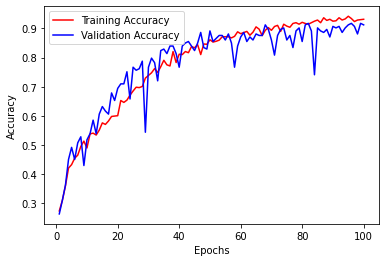

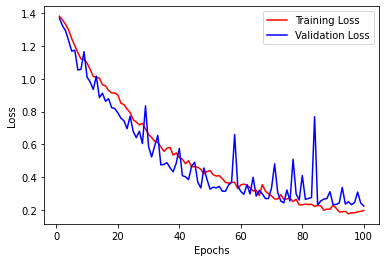

7/7 [==============================] - 1s 54ms/step - loss: 0.2709 - accuracy: 0.9171
Loss:  0.2709139585494995
Accuracy:  0.9170984625816345


In [9]:
#VISUALISING THE MODEL
acc = history.history['accuracy']
epochs = range(1, len(acc) + 1)
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, color='red', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

loss = history.history['loss']
epochs = range(1, len(loss) + 1)
val_loss = history.history['val_loss']
plt.plot(epochs, loss, color='red', label='Training Loss')
plt.plot(epochs, val_loss, color='blue', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

classifier = tf.keras.models.load_model('/content/drive/MyDrive/Brain Cancer/v3/DWT_Recons_L6.h5')
original_evaluation = classifier.evaluate(X_test, Y_test)
print('Loss: ',original_evaluation[0])
print('Accuracy: ',original_evaluation[1])

In [10]:
# Convert Keras model to TF Lite format.
converter = tf.lite.TFLiteConverter.from_keras_model(classifier)
tflite_float_model = converter.convert()

# Show model size in MBs.
float_model_size = len(tflite_float_model) / (1024*1024)
print('Float model size = %fKBs.' % float_model_size)

#Save the TFLite Model
with open("/content/drive/MyDrive/Brain Cancer/v3/DWT_Recons_L6_TFLite.tflite", "wb") as f:
  f.write(tflite_float_model)
print("Wrote %sTFLite model of %d bytes." , len(tflite_float_model))

INFO:tensorflow:Assets written to: /tmp/tmpv020y1eh/assets
Float model size = 0.675396KBs.
Wrote %sTFLite model of %d bytes. 708204


In [11]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / (1024*1024)
print('Quantized model size = %fMBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

#Save this Quantized TFLite Model
with open("/content/drive/MyDrive/Brain Cancer/v3/DWT_Recons_L6_TFLite_Quantized.tflite", "wb") as f:
  f.write(tflite_quantized_model)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if tflite_quantized_model else "", len(tflite_quantized_model)))

INFO:tensorflow:Assets written to: /tmp/tmpzsu2m5db/assets


INFO:tensorflow:Assets written to: /tmp/tmpzsu2m5db/assets


Quantized model size = 0.180725MBs,
which is about 26% of the float model size.
Wrote optimized TFLite model of 189504 bytes.


In [12]:
from tensorflow import keras

#Read the model in
tflite_model = '/content/drive/MyDrive/Brain Cancer/v3/DWT_Recons_L6_TFLite.tflite'
tflite_model_quantized = '/content/drive/MyDrive/Brain Cancer/v3/DWT_Recons_L6_TFLite_Quantized.tflite'

# Initialize TFLite interpreter using the model.
# Load TFLite model and allocate tensors.

#normal
interpreter = tf.lite.Interpreter(model_path=tflite_model)
interpreter.allocate_tensors()
#quantized
interpreter_q = tf.lite.Interpreter(model_path=tflite_model_quantized)
interpreter_q.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_details_q = interpreter_q.get_input_details()
output_details_q = interpreter_q.get_output_details()
n = 0  #count for accuracy
q = 0
normal = []
quantized = []
# Test model on input data.
for i in range(1, len(X_test)):
  test_image = np.expand_dims(X_test[i], axis=0).astype(np.float32)
  interpreter.set_tensor(input_details[0]['index'], test_image)
  interpreter_q.set_tensor(input_details_q[0]['index'], test_image)
  interpreter.invoke()
  interpreter_q.invoke()

  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  output_data = interpreter.get_tensor(output_details[0]['index'])
  output_data_q = interpreter_q.get_tensor(output_details_q[0]['index'])

  if np.argmax(output_data)==np.argmax(Y_test[i]):
    n+=1
  else:
    normal.append(i)

  if np.argmax(output_data_q)==np.argmax(Y_test[i]):
    q+=1
  else:
    quantized.append(i)
print('\n\nAccuracy of normal model= ', n/len(X_test))
print('\n\nAccuracy of quantized model= ', q/len(X_test))



Accuracy of normal model=  0.9119170984455959


Accuracy of quantized model=  0.9119170984455959


In [13]:
print('Wrongly classified images of normal model :', normal)
print('Wrongly classified images of quantized model :', quantized)

Wrongly classified images of normal model : [6, 10, 25, 27, 28, 39, 49, 82, 108, 110, 129, 130, 132, 135, 137, 163]
Wrongly classified images of quantized model : [6, 10, 25, 27, 28, 39, 49, 82, 108, 110, 129, 130, 132, 135, 137, 163]
